In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
#cargo primero los datos
file_dir = 'Datos/RiesgoBariloche'
data = pd.read_csv(file_dir,sep=",",quotechar='"',na_values=[''])
data = data["incidenciaAcum14d"]
df = pd.DataFrame(data)
df = df.to_numpy()
df1 = np.copy(df) #el original
df = df[:-20] #saco los ultimos 20 dias (ult 10 para probar + ult 10 retrasados)
df1 = df1[:-10] #saco los ultimos 10 dias retrasados

In [4]:
#normalizacion
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df.reshape(-1,1))
df += np.random.normal(0,0.01,df.shape)
df = df.reshape(-1,1)
#split en train y test
training_size=int(len(df)*0.8)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1] #train y test data
lag = 14 #creo que este es el que deducen en el paper
#creo los que vienen para la red
x_train, y_train = create_dataset(train_data, lag)
x_test, y_test = create_dataset(test_data, lag)

In [5]:
# reshape en (samples, time steps, features) para lstm como en pract7
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [6]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=4,activation='relu',input_shape=(lag,1)))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) #metrics=['mean_absolute_percentage_error']
model.summary()
history = model.fit(x_train, y_train,epochs=5000,validation_data=(x_test,y_test),batch_size=64,verbose=2) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 220 samples, validate on 44 samples
Epoch 1/5000
 - 1s - loss: 0.0739 - mse: 0.0739 - val_loss: 1.1221 - val_mse: 1.1221
Epoch 2/5000
 - 0s - loss: 0.0717 - mse: 0.0717 - val_loss: 1.0987 - val_mse: 1.0987
Epoch 3/5000
 - 0s - loss: 0.0696 - mse: 0.0696 - val_loss: 1.0760 - val_mse: 1.0760
Epoch 4/5000
 - 0s - loss: 0.0675 - mse: 0.0675 - val_loss: 1.0544 - val_mse: 1.0544
Epoch 5/5000
 - 0s - loss: 0.0655 - mse: 0.0655 - val_loss: 1.0336 - val_mse: 1.0336
Epoch 6/5000
 - 0s - loss: 0.0637 - mse: 0.0637 

Epoch 89/5000
 - 0s - loss: 0.0157 - mse: 0.0157 - val_loss: 0.3755 - val_mse: 0.3755
Epoch 90/5000
 - 0s - loss: 0.0155 - mse: 0.0155 - val_loss: 0.3722 - val_mse: 0.3722
Epoch 91/5000
 - 0s - loss: 0.0153 - mse: 0.0153 - val_loss: 0.3689 - val_mse: 0.3689
Epoch 92/5000
 - 0s - loss: 0.0151 - mse: 0.0151 - val_loss: 0.3657 - val_mse: 0.3657
Epoch 93/5000
 - 0s - loss: 0.0149 - mse: 0.0149 - val_loss: 0.3626 - val_mse: 0.3626
Epoch 94/5000
 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.3594 - val_mse: 0.3594
Epoch 95/5000
 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.3563 - val_mse: 0.3563
Epoch 96/5000
 - 0s - loss: 0.0144 - mse: 0.0144 - val_loss: 0.3530 - val_mse: 0.3530
Epoch 97/5000
 - 0s - loss: 0.0142 - mse: 0.0142 - val_loss: 0.3499 - val_mse: 0.3499
Epoch 98/5000
 - 0s - loss: 0.0140 - mse: 0.0140 - val_loss: 0.3468 - val_mse: 0.3468
Epoch 99/5000
 - 0s - loss: 0.0138 - mse: 0.0138 - val_loss: 0.3437 - val_mse: 0.3437
Epoch 100/5000
 - 0s - loss: 0.0137 - mse: 0.0137 - va

Epoch 184/5000
 - 0s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.1831 - val_mse: 0.1831
Epoch 185/5000
 - 0s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.1819 - val_mse: 0.1819
Epoch 186/5000
 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.1808 - val_mse: 0.1808
Epoch 187/5000
 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.1796 - val_mse: 0.1796
Epoch 188/5000
 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.1784 - val_mse: 0.1784
Epoch 189/5000
 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.1772 - val_mse: 0.1772
Epoch 190/5000
 - 0s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.1761 - val_mse: 0.1761
Epoch 191/5000
 - 0s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.1751 - val_mse: 0.1751
Epoch 192/5000
 - 0s - loss: 0.0051 - mse: 0.0051 - val_loss: 0.1740 - val_mse: 0.1740
Epoch 193/5000
 - 0s - loss: 0.0051 - mse: 0.0051 - val_loss: 0.1730 - val_mse: 0.1730
Epoch 194/5000
 - 0s - loss: 0.0051 - mse: 0.0051 - val_loss: 0.1720 - val_mse: 0.1720
Epoch 195/5000
 - 0s - loss: 0.0050 - mse: 

Epoch 279/5000
 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1120 - val_mse: 0.1120
Epoch 280/5000
 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1115 - val_mse: 0.1115
Epoch 281/5000
 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1109 - val_mse: 0.1109
Epoch 282/5000
 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1105 - val_mse: 0.1105
Epoch 283/5000
 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.1101 - val_mse: 0.1101
Epoch 284/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1097 - val_mse: 0.1097
Epoch 285/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 286/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 287/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1085 - val_mse: 0.1085
Epoch 288/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1082 - val_mse: 0.1082
Epoch 289/5000
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 290/5000
 - 0s - loss: 0.0030 - mse: 

 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0867 - val_mse: 0.0867
Epoch 374/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 375/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0864 - val_mse: 0.0864
Epoch 376/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 377/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 378/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 379/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0859 - val_mse: 0.0859
Epoch 380/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 381/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0855 - val_mse: 0.0855
Epoch 382/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0853 - val_mse: 0.0853
Epoch 383/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 384/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_lo

Epoch 468/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 469/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 470/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 471/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 472/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 473/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 474/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 475/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 476/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 477/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 478/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 479/5000
 - 0s - loss: 0.0026 - mse: 

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 563/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 564/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 565/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 566/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 567/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 568/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 569/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 570/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 571/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 572/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 573/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_lo

Epoch 657/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 658/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 659/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 660/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 661/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 662/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 663/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 664/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 665/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 666/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 667/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 668/5000
 - 0s - loss: 0.0026 - mse: 

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 752/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 753/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 754/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 755/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 756/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 757/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 758/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 759/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 760/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 761/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 762/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_lo

Epoch 846/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 847/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 848/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 849/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 850/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 851/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 852/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 853/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 854/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 855/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 856/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 857/5000
 - 0s - loss: 0.0026 - mse: 

Epoch 941/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 942/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 943/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 944/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 945/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 946/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 947/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 948/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 949/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 950/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 951/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 952/5000
 - 0s - loss: 0.0026 - mse: 

Epoch 1035/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1036/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1037/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 1038/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1039/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 1040/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 1041/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 1042/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 1043/5000
 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 1044/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1045/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 1046/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 1129/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 1130/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 1131/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 1132/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1133/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 1134/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1135/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1136/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 1137/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 1138/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1139/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 1222/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 1223/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 1224/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 1225/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 1226/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 1227/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 1228/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1229/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 1230/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 1231/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 1232/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 1233/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 1316/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 1317/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1318/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 1319/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 1320/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 1321/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 1322/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 1323/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1324/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1325/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 1326/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 1409/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 1410/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 1411/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 1412/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1413/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 1414/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 1415/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1416/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 1417/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 1418/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 1419/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1420/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 1503/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 1504/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 1505/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 1506/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1507/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 1508/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1509/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 1510/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 1511/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 1512/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 1513/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 1596/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 1597/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1598/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1599/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 1600/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 1601/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 1602/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 1603/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1604/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1605/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 1606/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 1607/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 1690/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 1691/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 1692/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0783 - val_mse: 0.0783
Epoch 1693/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0785 - val_mse: 0.0785
Epoch 1694/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 1695/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0791 - val_mse: 0.0791
Epoch 1696/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 1697/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 1698/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0791 - val_mse: 0.0791
Epoch 1699/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 1700/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 1783/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 1784/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 1785/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 1786/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 1787/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 1788/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 1789/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 1790/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 1791/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 1792/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 1793/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 1794/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 1877/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 1878/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 1879/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 1880/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 1881/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 1882/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 1883/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0749 - val_mse: 0.0749
Epoch 1884/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0746 - val_mse: 0.0746
Epoch 1885/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0745 - val_mse: 0.0745
Epoch 1886/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 1887/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 1970/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1971/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1972/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1973/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 1974/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 1975/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 1976/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1977/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1978/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 1979/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 1980/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 1981/5000
 - 0s - loss: 0.

Epoch 2064/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2065/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2066/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2067/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2068/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 2069/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2070/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2071/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2072/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2073/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 2074/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 2075/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 2158/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0783 - val_mse: 0.0783
Epoch 2159/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 2160/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 2161/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 2162/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 2163/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 2164/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 2165/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 2166/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 2167/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 2168/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 2251/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2252/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2253/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2254/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2255/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2256/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2257/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 2258/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 2259/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 2260/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 2261/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 2262/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 2345/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 2346/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 2347/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 2348/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2349/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2350/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0793 - val_mse: 0.0793
Epoch 2351/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2352/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2353/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0793 - val_mse: 0.0793
Epoch 2354/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0793 - val_mse: 0.0793
Epoch 2355/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 2438/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2439/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 2440/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 2441/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 2442/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2443/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2444/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2445/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 2446/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 2447/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 2448/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 2449/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2532/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2533/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 2534/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2535/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 2536/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 2537/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2538/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 2539/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 2540/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2541/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2542/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 2625/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 2626/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2627/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2628/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2629/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2630/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 2631/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 2632/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 2633/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 2634/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 2635/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 2636/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 2719/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 2720/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 2721/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2722/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2723/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2724/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2725/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 2726/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 2727/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 2728/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 2729/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 2812/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 2813/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 2814/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 2815/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2816/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 2817/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 2818/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2819/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 2820/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 2821/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 2822/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 2823/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2906/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2907/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 2908/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 2909/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2910/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2911/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2912/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0793 - val_mse: 0.0793
Epoch 2913/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2914/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 2915/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0791 - val_mse: 0.0791
Epoch 2916/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 2999/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 3000/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 3001/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 3002/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 3003/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 3004/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 3005/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 3006/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 3007/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 3008/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 3009/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 3010/5000
 - 0s - loss: 0.

Epoch 3093/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3094/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3095/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 3096/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0751 - val_mse: 0.0751
Epoch 3097/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 3098/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 3099/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3100/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 3101/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 3102/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3103/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3104/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3187/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3188/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3189/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3190/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3191/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3192/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3193/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3194/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3195/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3196/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3197/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 3280/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0753 - val_mse: 0.0753
Epoch 3281/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 3282/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 3283/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 3284/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3285/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3286/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3287/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3288/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3289/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3290/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3291/5000
 - 0s - loss: 0.

Epoch 3374/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 3375/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0760 - val_mse: 0.0760
Epoch 3376/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 3377/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3378/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3379/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3380/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3381/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3382/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3383/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3384/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3385/5000
 - 0s - loss: 0.

Epoch 3468/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3469/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3470/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3471/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3472/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3473/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 3474/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 3475/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 3476/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 3477/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 3478/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 3479/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3562/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 3563/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 3564/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 3565/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 3566/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 3567/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3568/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 3569/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3570/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3571/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3572/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 3655/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3656/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3657/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3658/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3659/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3660/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3661/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3662/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 3663/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 3664/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3665/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3666/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3749/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3750/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3751/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3752/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3753/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3754/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 3755/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 3756/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 3757/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3758/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3759/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 3842/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3843/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3844/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3845/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 3846/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3847/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3848/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3849/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 3850/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3851/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3852/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3853/5000
 - 0s - loss: 0.

Epoch 3936/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 3937/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 3938/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3939/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 3940/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3941/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 3942/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 3943/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 3944/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 3945/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 3946/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 3947/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 4030/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4031/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4032/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4033/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4034/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4035/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4036/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4037/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4038/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4039/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4040/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 4123/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 4124/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 4125/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 4126/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4127/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4128/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4129/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4130/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4131/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4132/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4133/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4134/5000
 - 0s - loss: 0.

Epoch 4217/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4218/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4219/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 4220/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4221/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4222/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 4223/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 4224/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4225/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 4226/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4227/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4228/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 4311/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4312/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4313/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4314/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4315/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4316/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4317/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 4318/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4319/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4320/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4321/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 4404/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4405/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4406/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4407/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4408/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 4409/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 4410/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0786 - val_mse: 0.0786
Epoch 4411/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0787 - val_mse: 0.0787
Epoch 4412/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 4413/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 4414/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0788 - val_mse: 0.0788
Epoch 4415/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4498/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4499/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4500/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4501/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4502/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4503/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 4504/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4505/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 4506/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4507/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4508/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 4591/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4592/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4593/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4594/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 4595/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 4596/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 4597/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 4598/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 4599/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 4600/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0780 - val_mse: 0.0780
Epoch 4601/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4602/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4685/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4686/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4687/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0767 - val_mse: 0.0767
Epoch 4688/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 4689/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 4690/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 4691/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 4692/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4693/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4694/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4695/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 4778/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4779/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4780/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4781/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4782/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4783/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4784/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4785/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0775 - val_mse: 0.0775
Epoch 4786/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4787/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4788/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4789/5000
 - 0s - loss: 0.

 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4872/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 4873/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4874/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4875/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4876/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 4877/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4878/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 4879/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0772 - val_mse: 0.0772
Epoch 4880/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 4881/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 4882/5000
 - 0s - loss: 0.0026 - mse: 0.00

Epoch 4965/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 4966/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4967/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 4968/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 4969/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4970/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4971/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4972/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4973/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 4974/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0758 - val_mse: 0.0758
Epoch 4975/5000
 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 4976/5000
 - 0s - loss: 0.

In [7]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [8]:
print('train mse squared:',mean_squared_error(y_train,train_predict))
print('test mse squared:',mean_squared_error(y_test,test_predict)) 

train mse squared: 0.0025976559625869164
test mse squared: 0.07620193366091249


In [9]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

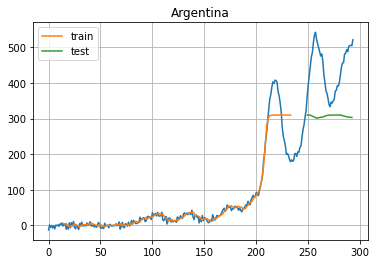

In [10]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(train_predict)+lag, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lag*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,label='test')
plt.grid()
plt.title('Argentina')
plt.legend()
plt.show()

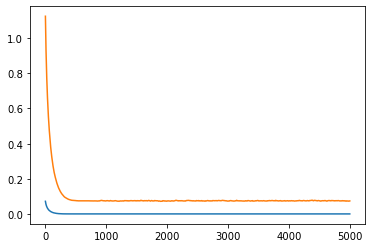

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# aca hacemos el forecast

In [12]:
n = len(test_data)
x_input=test_data[n-lag:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=lag
i=0

while(i<10): 
    if(len(temp_input)>lag):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, lag, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, lag,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

1 day output [[0.5740526]]
2 day output [[0.57737654]]
3 day output [[0.5794689]]
4 day output [[0.58078325]]
5 day output [[0.58160776]]
6 day output [[0.58212495]]
7 day output [[0.5824492]]
8 day output [[0.5826528]]
9 day output [[0.58278066]]


In [13]:
lst_output = scaler.inverse_transform(lst_output)

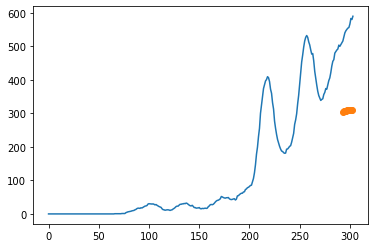

In [14]:
plt.plot(df1)
dias_forecast = np.arange(0,10) + len(df) - 1
plt.plot(dias_forecast,lst_output,'o')
#plt.xlim(290,310)

(290.0, 310.0)

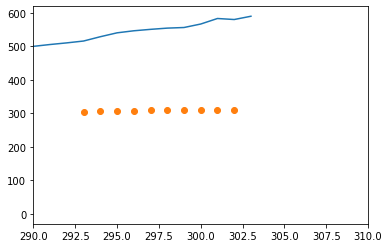

In [15]:
plt.plot(df1)
dias_forecast = np.arange(0,10) + len(df) - 1
plt.plot(dias_forecast,lst_output,'o')
plt.xlim(290,310)

In [16]:
print(df1[-10:]-lst_output)

[[225.58031438]
 [234.5139698 ]
 [238.85297678]
 [242.01497648]
 [244.98011581]
 [246.3736721 ]
 [256.48068611]
 [272.79746233]
 [269.63559047]
 [279.3389921 ]]
